In [1]:
from quantile_regression.linear_quantile import LinearVectorQuantileRegression
from old_source_code.data import create_joint_x_y
import numpy as np
import torch

X, Y = create_joint_x_y(100)
X_batch = torch.from_numpy(np.concatenate([X, np.ones((100, 1))], axis=1))
Y_batch = torch.from_numpy(Y)
dataloader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_batch, Y_batch), batch_size=100, shuffle=True)

lvqr = LinearVectorQuantileRegression(num_latent_points_to_generate=600)
_ = lvqr.fit(dataloader)

(1300,)


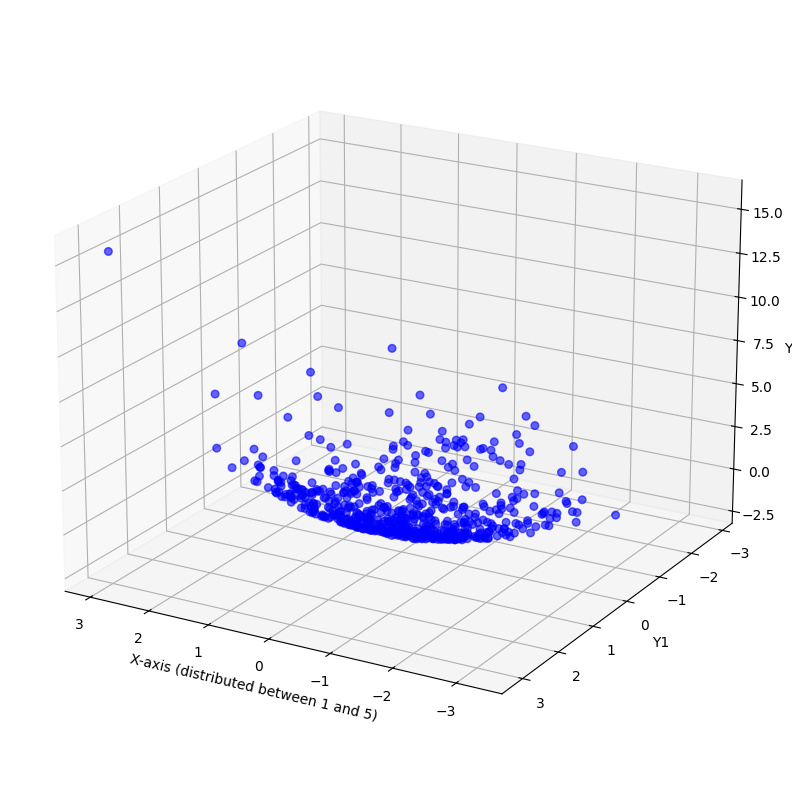

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

x = X_batch[0:1, :].cpu().numpy()
phi_dual_potential = - lvqr.b_u @ x.T

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(lvqr.u[:,0 ], lvqr.u[:, 1], phi_dual_potential.flatten(), c='blue', marker='o', s=30, alpha=0.6)

ax.set_xlabel('X-axis (distributed between 1 and 5)')
ax.set_ylabel('Y1')
ax.set_zlabel('Y2')

ax.grid(True)
ax.view_init(elev=20, azim=120)

plt.show()

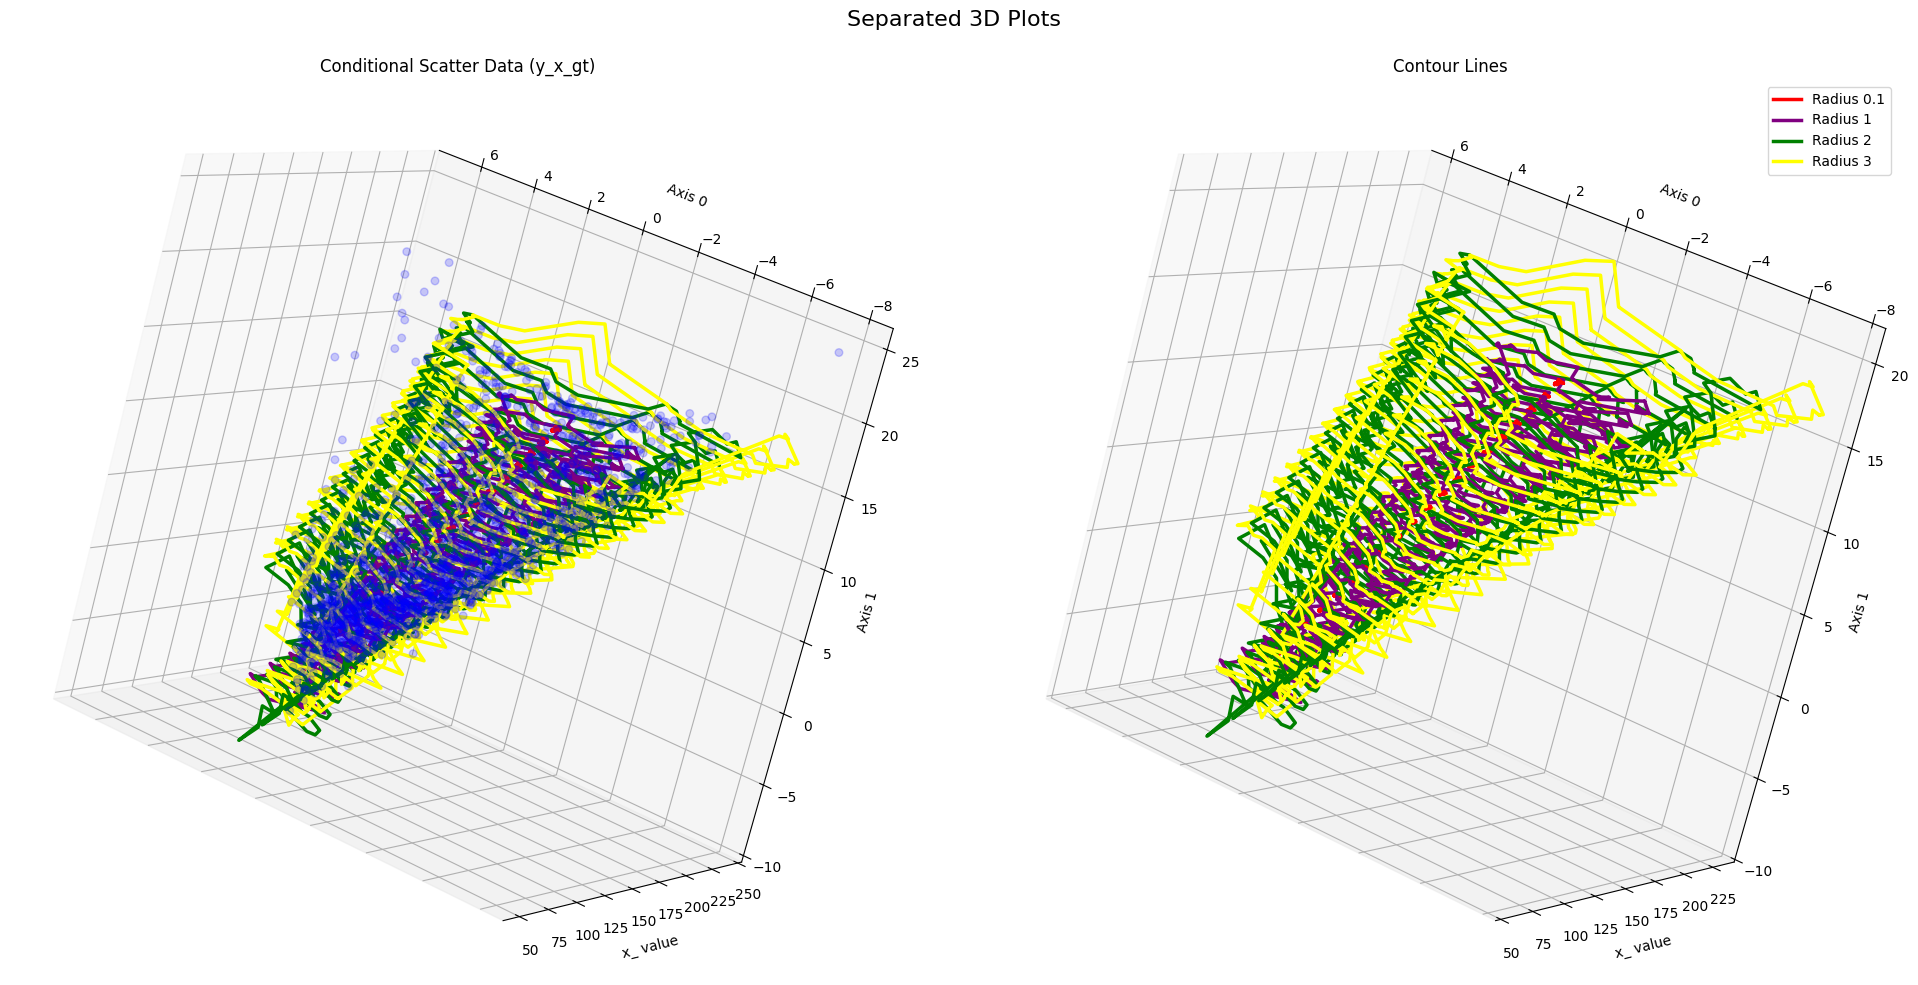

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
from old_source_code.data import create_conditional_x

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10), subplot_kw={'projection': '3d'})
fig.suptitle('Separated 3D Plots', fontsize=16)

ax1.set_title('Conditional Scatter Data (y_x_gt)')
ax1.set_xlabel('Axis 0')
ax1.set_ylabel('Axis 1')
ax1.set_zlabel('x_ value')

for x_ in range(50, 250, 10):
    x = np.array([x_ / 100, 1])

    # This section is now active for the first plot
    _, y_x_gt = create_conditional_x(n_points=100, x_value=x[0])
    z_scatter = np.full(y_x_gt.shape[0], x_)
    ax1.scatter(y_x_gt[:, 0], y_x_gt[:, 1], z_scatter, color='blue', marker='o', s=30, alpha=0.2)

ax1.view_init(elev=-55, azim=154, roll=-83)

ax2.set_title('Contour Lines')
ax2.set_xlabel('Axis 0')
ax2.set_ylabel('Axis 1')
ax2.set_zlabel('x_ value')

loop_start_value = 50
for x_ in range(loop_start_value, 250, 10):
    x = np.array([x_ / 100, 1])[None, :].repeat(100, 0)
    X_batch = torch.from_numpy(x)

    colors = ['red', 'purple', 'green', 'yellow']
    radii = [0.1, 1, 2, 3]

    for contour_radius, color in zip(radii, colors):
        pi = np.linspace(-np.pi, np.pi, 100) # Use linspace for a perfectly smooth circle

        u = np.stack([
            contour_radius * np.cos(pi),
            contour_radius * np.sin(pi),
        ]).T

        pushforward_of_u = lvqr.push_forward_u_given_x(torch.from_numpy(u), X=X_batch)
        z_line = np.full(pushforward_of_u.shape[0], x_)

        label = f'Radius {contour_radius}' if x_ == loop_start_value else ""
        ax2.plot(pushforward_of_u[:, 0], pushforward_of_u[:, 1], z_line, color=color, linewidth=2.5, label=label)
        ax1.plot(pushforward_of_u[:, 0], pushforward_of_u[:, 1], z_line, color=color, linewidth=2.5, label=label)

ax2.view_init(elev=-55, azim=154, roll=-83)
ax2.legend()

plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust layout to make room for suptitle
plt.show()